# Reservoir Computing clásico y cuántico en EEG reales usando ventana de Hann.

## Carga de librerías.

In [1]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert, butter, filtfilt, windows
from sklearn.cluster import KMeans
import pandas as pd
import random
from scipy.io import loadmat

## Carga de los datos.

In [2]:
# Cargamos el fichero .mat
eegs = loadmat('data/data/Yolanda_EEG_RS_2024.mat')

# Mostrar las claves del diccionario cargado
print(eegs.keys())

dict_keys(['__header__', '__version__', '__globals__', 'S13_OA_RS', 'S2_YA_RS'])


In [3]:
# cogemos las variables S13_OA_RS y S2_YA_RS que corresponden a dos EEGs.
s_13_old = eegs['S13_OA_RS']
print(s_13_old.shape)

(64, 160768)


In [4]:
s_2_young = eegs['S2_YA_RS']
print(s_2_young.shape)

(64, 154976)


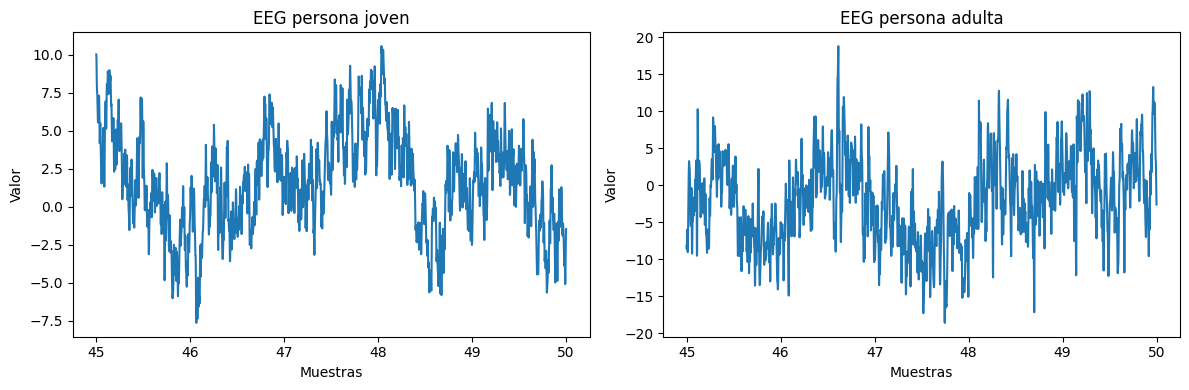

In [5]:
# Graficamos el primer canal de ambos EEGs.

# Creamos una figura con 1 fila y 2 columnas
fig, axs = plt.subplots(1, 2, figsize=(12, 4))  # ancho x alto en pulgadas

# Creamos un vector de tiempo que corresponde con el tiempo de duración de las señales.

# Parámetros
fs = 512  # frecuencia de muestreo
inicio_s = 45
fin_s = 50

# Índices de muestra
inicio_idx = int(inicio_s * fs)
fin_idx = int(fin_s * fs)

# Extraer la ventana
s_2_young_ventana = s_2_young[:, inicio_idx:fin_idx]

# Crear vector de tiempo relativo a la ventana
t1 = np.linspace(inicio_s, fin_s, fin_idx - inicio_idx)

# Primer gráfico
axs[0].plot(t1, s_2_young_ventana[0,:])
axs[0].set_title('EEG persona joven')
axs[0].set_xlabel('Muestras')
axs[0].set_ylabel('Valor')

# Extraemos la ventana del segundo EEG.
s_13_old_ventana = s_13_old[:, inicio_idx:fin_idx]

# Segundo gráfico
axs[1].plot(t1, s_13_old_ventana[0,:])
axs[1].set_title('EEG persona adulta')
axs[1].set_xlabel('Muestras')
axs[1].set_ylabel('Valor')

# Ajustar espacios
plt.tight_layout()
plt.show()

## RC Clásico en Sujeto Joven 2.

In [12]:
# Implementación reservoir clásico con un sujeto joven.

# Parámetros
num_input_channels = 64     # Dimensionalidad de entrada (64 canales)
num_reservoir_neurons = 10   # Número de neuronas en el reservorio
num_readout_neurons = 1      # Número de neuronas de salida

num_training_samples = s_2_young.shape[1] # Número de muestras de entrenamiento

# Generar pesos de entrada al reservorio
input2res = np.random.randn(num_reservoir_neurons, num_input_channels)

# Generar pesos recurrentes del reservorio
res2res = np.random.randn(num_reservoir_neurons, num_reservoir_neurons)

# Normalización espectral
eigvals = np.linalg.eigvals(res2res)
spectral_radius = np.max(np.abs(eigvals))
desired_radius = 0.9

# Escalar la matriz recurrente
res2res = (res2res / spectral_radius) * desired_radius

# Sesgo del reservorio
input_bias = np.random.rand(num_reservoir_neurons, 1)

# Estados iniciales del reservorio
#reservoir_states = np.zeros((num_reservoir_neurons, num_training_samples + 1))
reservoir_states = np.random.randn(num_reservoir_neurons,num_training_samples + 1);

# Dinámicas del reservorio
for i in range(num_training_samples):
    reservoir_states[:, i + 1] = np.tanh(
        (0.05 * input2res @ s_2_young[:, i]) +
        (0.95 * res2res @ reservoir_states[:, i]) +
        input_bias.flatten()
    )

# Eliminamos la componente DC de la señal.
RS_clasico_joven2 = reservoir_states - np.mean(reservoir_states, axis = 1, keepdims=True)

# Aplicamos un filtro pasa-banda sobre la salida con una frecuencia entre 4 y 12 Hz.
def bandpass_filter(signal, fs, lowcut, highcut, order=4):
    nyq = fs / 2
    b, a = butter(order, [lowcut / nyq, highcut / nyq], btype='band')
    return filtfilt(b, a, signal, axis=1)  # aplica por columnas

# frecuencia de muestreo: 512 Hz.
RS_filtered = bandpass_filter(RS_clasico_joven2, fs, 4, 12)

# Hilbert sobre la señal filtrada para sacar la envolvente.
analytic_signal = hilbert(RS_filtered, axis=1)
amplitude_envelope_clasico_joven2 = np.abs(analytic_signal)

import pywt

def wavelet_denoise_matrix(envelope, wavelet='db4', level=3, mode='soft'):
    """
    Función que aplica Wavelet Denoising a cada fila (neuronas) de la envolvente que tenemos
    como resultado de la transformada de Hilbert 
    """
    denoised_matrix = np.zeros_like(envelope)
    num_channels, num_samples = envelope.shape

    for i in range(num_channels):
        signal = envelope[i,:]
        coeffs = pywt.wavedec(signal, wavelet=wavelet, level=level)
        
        # Umbral automático basado en ruido
        sigma = np.median(np.abs(coeffs[-1])) / 0.6745
        threshold = sigma * np.sqrt(2 * np.log(len(signal)))
        
        coeffs_denoised = [pywt.threshold(c, threshold, mode=mode) for c in coeffs]
        reconstructed = pywt.waverec(coeffs_denoised, wavelet=wavelet)
        
        # Asegurar tamaño original
        denoised_matrix[i] = reconstructed[:num_samples]

    return denoised_matrix

# Aplica el suavizado wavelet
smoothed_envelope_clasico_joven2 = wavelet_denoise_matrix(amplitude_envelope_clasico_joven2)

print(analytic_signal.shape)
print(RS_clasico_joven2.shape)
print(smoothed_envelope_clasico_joven2.shape)

(10, 154977)
(10, 154977)
(10, 154977)


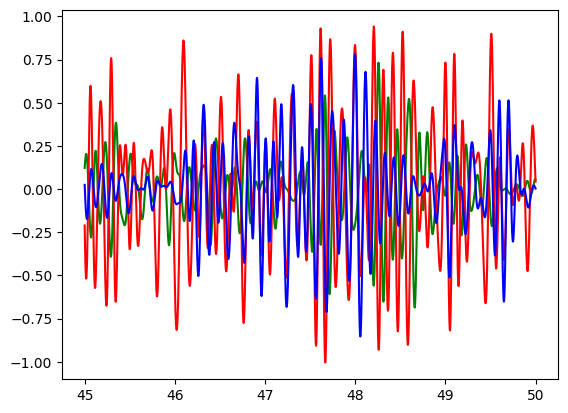

In [13]:
# Mostramos los últimos 5 segundos.

plt.plot(t1, RS_filtered[0, inicio_idx:fin_idx], color = 'green')
plt.plot(t1, RS_filtered[1, inicio_idx:fin_idx], color = 'red')
plt.plot(t1, RS_filtered[2, inicio_idx:fin_idx], color = 'blue')
plt.show()

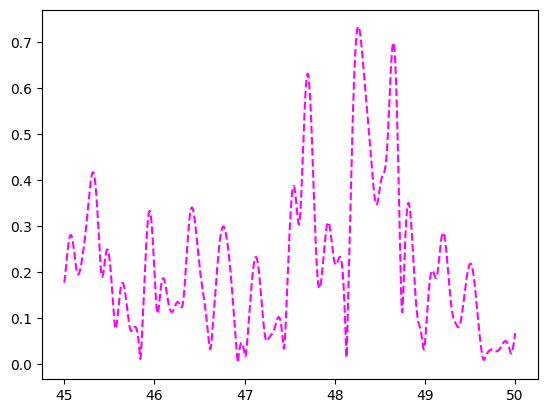

In [14]:
input_sequence_clasico_joven2 = smoothed_envelope_clasico_joven2
plt.plot(t1, input_sequence_clasico_joven2[0, inicio_idx:fin_idx], linestyle="dashed", color = 'magenta')
plt.show()

In [15]:
# Agrupamiento con Gaussian Mixture Model(GMM)

from sklearn.mixture import GaussianMixture

def clustering_gmm(input_sequence, n_components=4):  
    """  
    Función para realizar agrupamiento usando GMM.  

    Args:  
    - input_sequence: Array de entrada procesado para el agrupamiento.  
    - num_clusters: Número de estados cerebrales. Default es 4.  

    Returns:  
    - labels: Etiquetas de los clústeres asignados a cada muestra de entrada. 
    """
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    cluster_labels = gmm.fit_predict(input_sequence.T)
    return cluster_labels

idx_clasico_joven2_gmm = clustering_gmm(input_sequence_clasico_joven2)

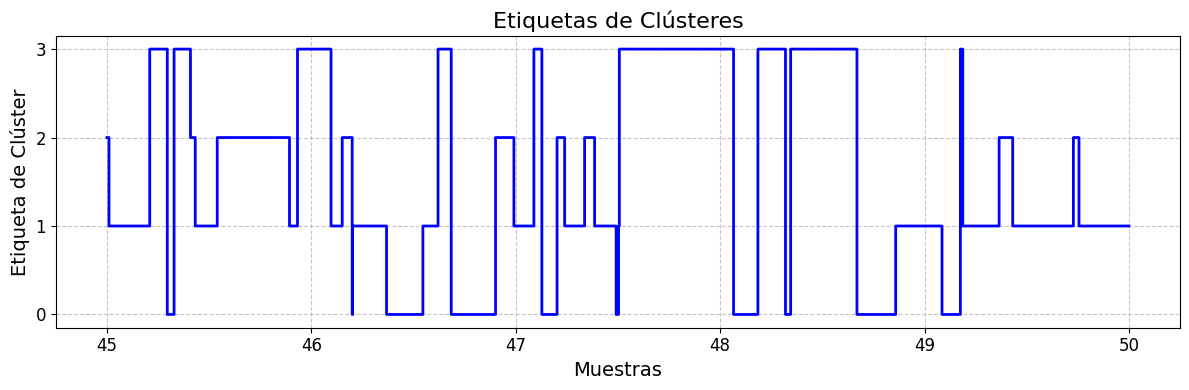

In [16]:
plt.figure(figsize=(12, 4))  
plt.step(t1, idx_clasico_joven2_gmm[inicio_idx:fin_idx], where='post', color='blue', linewidth=2) 
plt.title('Etiquetas de Clústeres', fontsize=16)
plt.xlabel('Muestras', fontsize=14)  
plt.ylabel('Etiqueta de Clúster', fontsize=14)  
plt.yticks(np.arange(4))  
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)  
plt.grid(True, linestyle='--', alpha=0.7)  
plt.tight_layout() 
plt.show()